### Import Packages

In [1]:
import cv2
import glob
import time
import random
import pickle
import numpy as np
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Load Datas and Visualize some Images

In [2]:
car_images = glob.glob('./datasets/vehicles/**/*.png')
notcar_images = glob.glob('./datasets/non-vehicles/**/*.png')

print('The number of training images for car images is', len(car_images))
print('The number of training images for non-car images is', len(notcar_images))

The number of training images for car images is 8792
The number of training images for non-car images is 8968


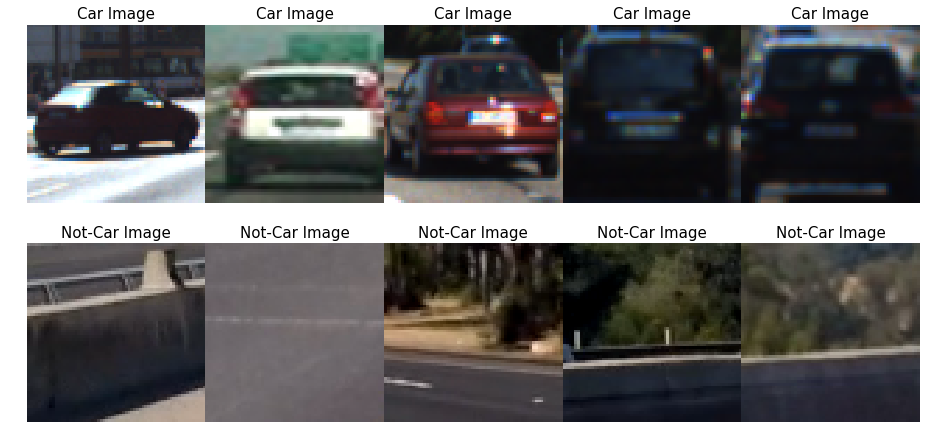

In [3]:
fig, axs = plt.subplots(2,5, figsize=(16, 8))
fig.subplots_adjust(hspace = .01, wspace=.001)
axs = axs.ravel()

for i in np.arange(5):
    image = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Car Image', fontsize=15)
    axs[i].imshow(image)
    
for i in np.arange(5,10):
    image = cv2.imread(notcar_images[np.random.randint(0,len(notcar_images))])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Not-Car Image', fontsize=15)
    axs[i].imshow(image)

### Get HOG Features

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

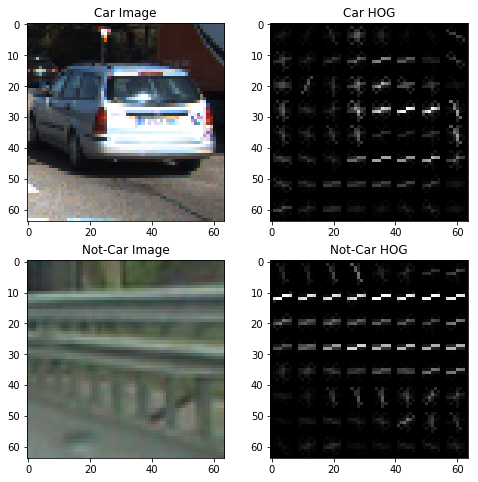

In [5]:
car_img = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
notcar_img = mpimg.imread(notcar_images[np.random.randint(0,len(notcar_images))])

car_gray = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2GRAY)

car_features, car_hog_image = get_hog_features(car_gray, 9, 8, 2, vis=True, feature_vec=False)
notcar_features, notcar_hog_image = get_hog_features(notcar_gray, 9, 8, 2, vis=True, feature_vec=False)

plt.subplots(figsize = (8, 8))
plt.subplot(221)
plt.imshow(car_img)
plt.title('Car Image')
plt.subplot(222)
plt.imshow(car_hog_image, cmap='gray')
plt.title('Car HOG')
plt.subplot(223)
plt.imshow(notcar_img)
plt.title('Not-Car Image')
plt.subplot(224)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('Not-Car HOG')

### Extract Features

In [6]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### Train SVM and Tune Hyperparameters

In [7]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

88.3 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292


In [8]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

7.68 Seconds to train SVC...
Test Accuracy of SVC =  0.9814
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  1.  1.  1.  0.]
0.0156 Seconds to predict 10 labels with SVC


### Detect Cars in an Image Using HOG Subsampling

In [9]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            test_prediction = svc.predict(hog_features)
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [10]:
test_img = mpimg.imread('./test_images/test1.jpg')

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
ystart = 400
ystop = 656
scale = 1.5

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                       None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

11 rectangles found in image


### Visualize Find Cars Method

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

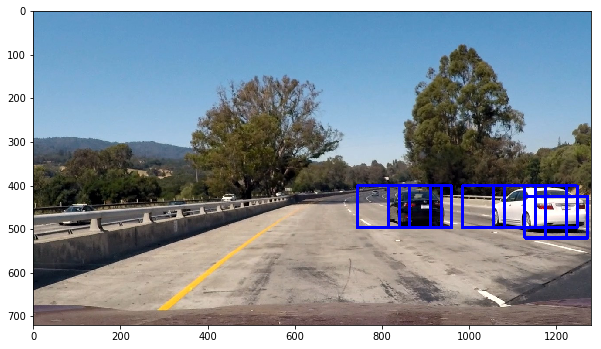

In [12]:
rects_img = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(rects_img)

### Generate Heatmaps

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

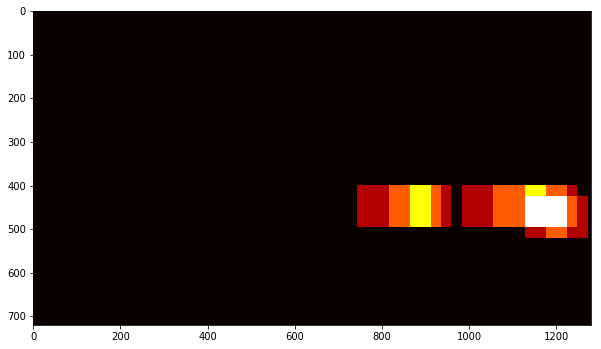

In [14]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

In [15]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

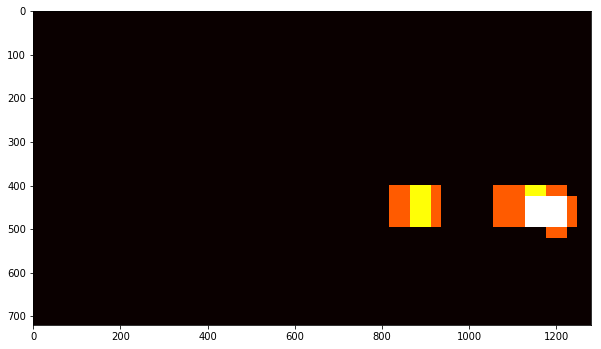

In [16]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


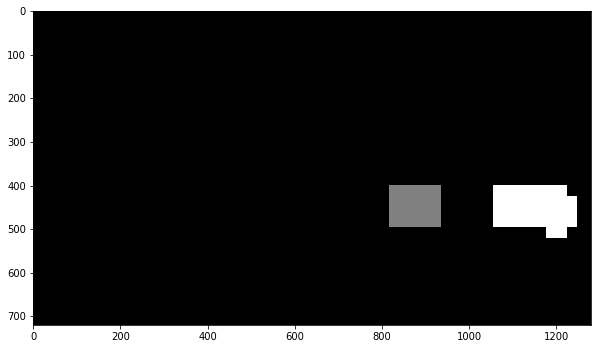

In [17]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

In [18]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

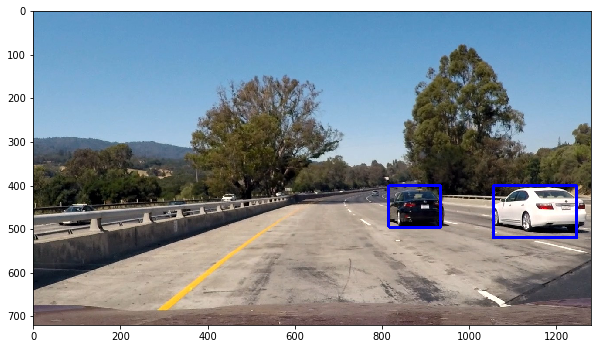

In [19]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### Process the video

In [20]:
def detect_cars(img):

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient =9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    sliding_windows = [[400, 464, 1.0],
                      [416, 480, 1.0],
                      [400, 496, 1.5],
                      [432, 528, 1.5],
                      [400, 528, 2.0],
                      [432, 560, 2.0],
                      [400, 596, 3.5],
                      [464, 660, 3.5]]
    
    rectangles = []
    for i in range(len(sliding_windows)):
        ystart = sliding_windows[i][0]
        ystop = sliding_windows[i][1]
        scale = sliding_windows[i][2]
        found_cars = find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None)
        rectangles.append(found_cars)

    rectangles = [item for sublist in rectangles for item in sublist] 
        
    # Create an empty image
    heatmap_img = np.zeros_like(img[:,:,0])
    
    # Create a heatmap from image in the bounding box
    heatmap_img = add_heat(heatmap_img, rectangles)
    
    # Threshold the heatmap
    heatmap_img = apply_threshold(heatmap_img, 1)
    
    # Label featurees in the heatmap
    labels = label(heatmap_img)
    
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

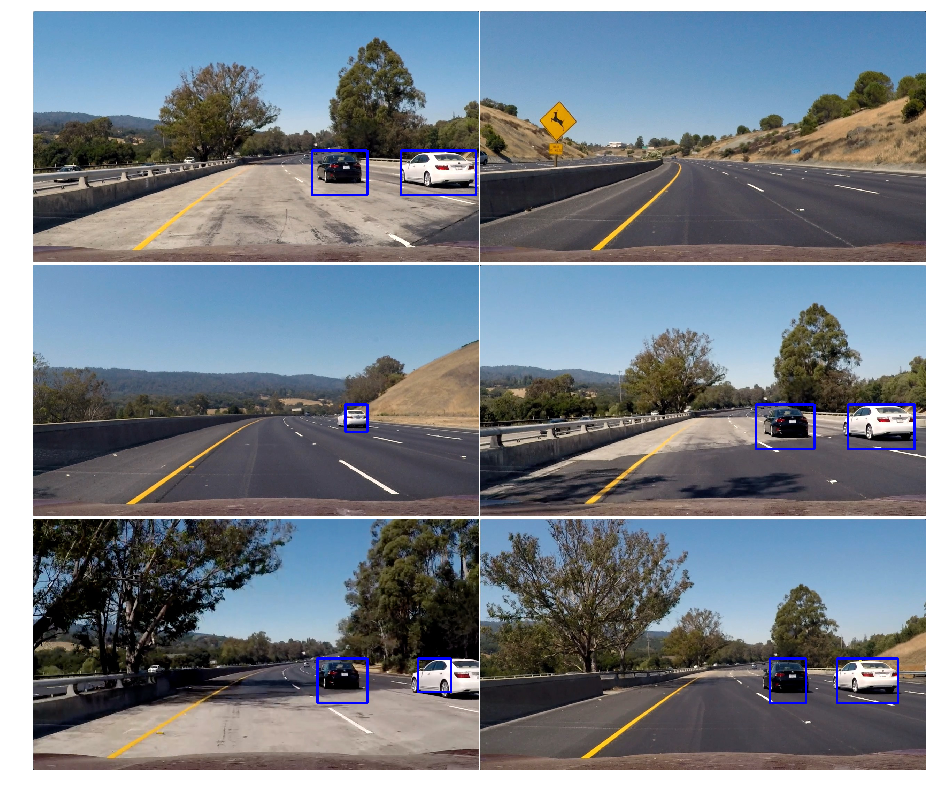

In [21]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(detect_cars(mpimg.imread(im)))
    axs[i].axis('off')

In [22]:
clip_test = VideoFileClip('test_video.mp4')
clip_test_output = clip_test.fl_image(detect_cars)
%time clip_test_output.write_videofile('test_video_output.mp4', audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:25<00:00,  1.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 27.5 s


In [23]:
# Define a class to store data from video
class Detection_History():
    def __init__(self):
        self.history = [] 
        
    def add_rectangles(self, rectangles):
        self.history.append(rectangles)
        
        # Discard if the history grows more than 15
        if len(self.history) > 15:
            self.history = self.history[len(self.history)-15:]

In [24]:
def detect_vehicles(img):

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    sliding_windows = [[400, 464, 1.0],
                      [416, 480, 1.0],
                      [400, 496, 1.5],
                      [432, 528, 1.5],
                      [400, 528, 2.0],
                      [432, 560, 2.0],
                      [400, 596, 3.5],
                      [464, 660, 3.5]]

    rectangles = []
    for i in range(len(sliding_windows)):
        ystart = sliding_windows[i][0]
        ystop = sliding_windows[i][1]
        scale = sliding_windows[i][2]
        found_cars = find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None)
        rectangles.append(found_cars)

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # Add the current frame to history
    if len(rectangles) > 0:
        detection_history.add_rectangles(rectangles)
    
    # Create an empty image
    heatmap_img = np.zeros_like(img[:,:,0])
    
     # Create a heatmap from image in the bounding box
    for rectangle in detection_history.history:
        heatmap_img = add_heat(heatmap_img, rectangle)
        
    # Threshold the heatmap
    heatmap_img = apply_threshold(heatmap_img, 1 + len(detection_history.history)//2)
    
    # Label featurees in the heatmap
    labels = label(heatmap_img)
    
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [25]:
detection_history = Detection_History()

clip_project = VideoFileClip('project_video.mp4')
clip_project_output = clip_project.fl_image(detect_vehicles)
%time clip_project_output.write_videofile('project_video_output.mp4', audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [14:48<00:00,  1.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 14min 50s
